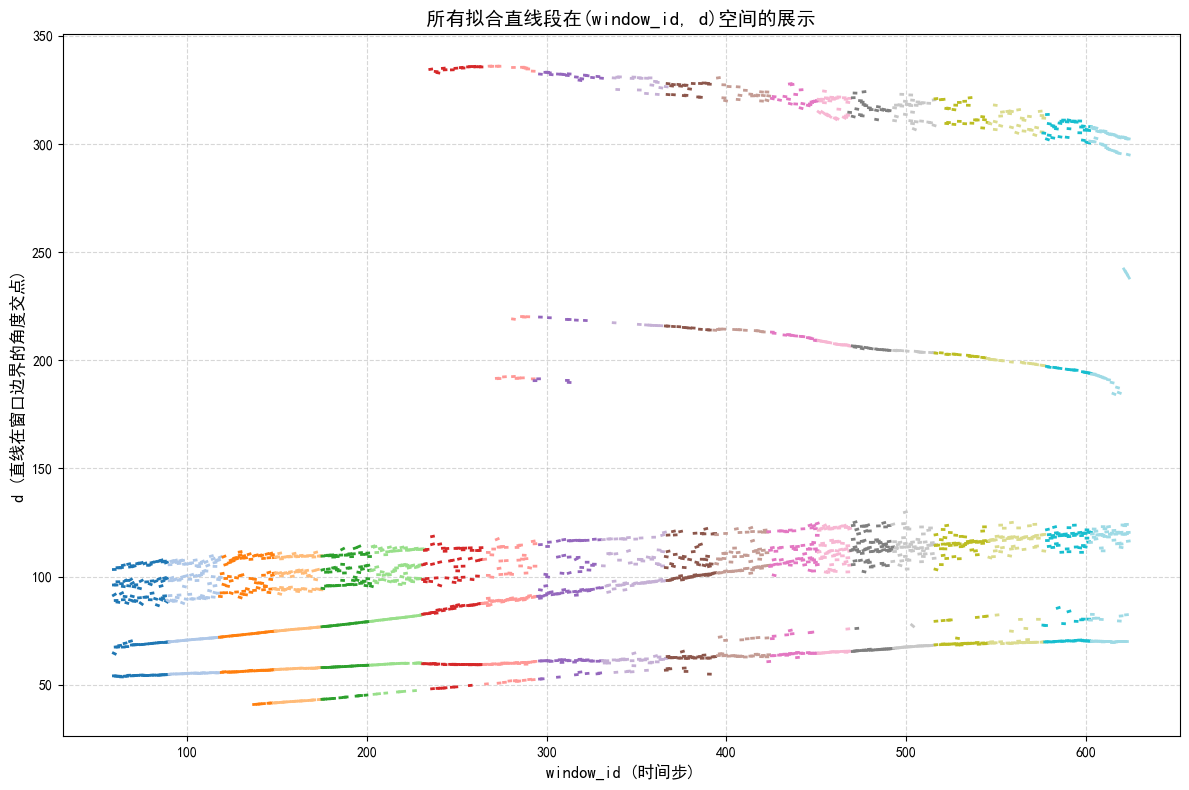

In [4]:
import pickle
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams['font.sans-serif'] = ['SimHei']  # 使用黑体显示中文
plt.rcParams['axes.unicode_minus'] = False    # 正常显示负号

with open("intersection_points.pkl", "rb") as f:
#with open("d:/xjy/Program/MOT/HO-MHT-master/examples/linear_model/12501259.pkl", "rb") as f:
    intersection_points = pickle.load(f)
    # 设置画布
plt.figure(figsize=(12, 8))
colors = plt.cm.tab20(np.linspace(0, 1, len(intersection_points)))

# 遍历所有直线信息进行绘图
for i, item in enumerate(intersection_points):
    window_id = item['window_id']
    theta = item['theta']
    d_left = item['left']
    d_right = item['right']

    # 计算直线两个端点的坐标（x: 时间轴，y: 角度）
    x_vals = [d_left[0], d_right[0]]
    y_vals = [d_left[1], d_right[1]]

    # 绘制直线
    plt.plot(x_vals, y_vals, color=colors[i % len(colors)], linewidth=2)

# 图像美化
plt.title("所有拟合直线段在(window_id, d)空间的展示", fontsize=14)
plt.xlabel("window_id (时间步)", fontsize=12)
plt.ylabel("d (直线在窗口边界的角度交点)", fontsize=12)
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

In [5]:
from collections import defaultdict
from typing import List, Dict, Any, OrderedDict
import operator

def group_by_window(intersection_points: List[Dict[str, Any]]) -> Dict[int, List[Dict[str, Any]]]:
    """
    将 intersection_points 按 window_id 分组，并返回一个以 window_id 升序排列的字典。
    """
    # 1) 按 window_id 分组
    windows = defaultdict(list)
    for seg in intersection_points:
        w = seg['window_id']
        windows[w].append(seg)

    # 2) 按 window_id 排序，返回普通 dict（Py3.7+ 保持插入顺序）
    grouped = dict()
    for w in sorted(windows.keys()):
        grouped[w] = windows[w]

    return grouped

# 用法示例
grouped_data = group_by_window(intersection_points)

In [6]:
# test
for t,detections in grouped_data.items():
    if t>2:
        break
    print(f"Time step {t}: {len(detections)} segments")
    
    for z in detections:
        print(z)

Time step 0: 4 segments
{'traj_id': 0, 'window_id': 0, 'left': (59, np.float64(95.8051566317375)), 'right': (60, np.float64(95.69738648618453)), 'theta': np.float64(1.4634405263089736), 'd': np.float64(98.20892211637188)}
{'traj_id': 1, 'window_id': 0, 'left': (59, np.float64(54.086435028414165)), 'right': (60, np.float64(54.10809789690003)), 'theta': np.float64(-1.5491368460045947), 'd': np.float64(-49.58718865167015)}
{'traj_id': 2, 'window_id': 0, 'left': (59, np.float64(105.18041091677193)), 'right': (60, np.float64(105.49913274108044)), 'theta': np.float64(-1.2622532602706134), 'd': np.float64(-83.44188131565154)}
{'traj_id': 3, 'window_id': 0, 'left': (59, np.float64(91.0369847164405)), 'right': (60, np.float64(91.50686160866486)), 'theta': np.float64(-1.1315362779162284), 'd': np.float64(-57.72774589623151)}
Time step 1: 4 segments
{'traj_id': 4, 'window_id': 1, 'left': (60, np.float64(96.47013078050921)), 'right': (61, np.float64(96.47401955870521)), 'theta': np.float64(-1.5669

In [19]:
from collections import (deque)
from copy import (deepcopy)
class Target:

    def __init__(self, z, t_now):
        self._time = t_now
        self._time_hit = t_now
        self._hit_history = deque(maxlen=5)
        self._hit_history.append(True)
        self._left = z['left']
        self._right = z['right']
        self._theta = z['theta']
        self._d = z['d']
    
    def update_hit(self, t_now):
        self._time_hit = t_now
        self._hit_history.append(True)

    def update_miss(self, t_now):
        self._hit_history.append(False)
    
    def is_confirmed(self):
        return len(self._hit_history)>2 and self._hit_history.count(True)>=2
    
    def is_dead(self):
        timeout = (self._time - self._time_hit) > self.max_coast_time()
        return timeout or (len(self._hit_history) > 2 and self._hit_history.count(True) < 2)
    
    def geting(self,z):
        return
    
    @classmethod
    def from_one_detection(cls, detection, t_now):
        return cls(
            z = detection,
            t_now=t_now
        )
    
    def max_coast_time(self):
        return 5.0

class Hypothesis:

    def __init__(self, target):
        self._target = target
        self._hid = self.__class__._counter
        self.__class__._counter += 1
    
    def id(self):
        return self._hid
    
    def is_dead(self):
        return self._target.is_dead()

    def is_confirmed(self):
        return self._target.is_confirmed()
    #下面声明类方法(不用self)
    @classmethod
    def new_from_hit(cls, self):
        target = deepcopy(self._target)
        return cls(
            target = target
        )

    @classmethod
    def new_from_miss(cls, self, t_now):
        target = deepcopy(self._target)
        target.update_miss(t_now)
        return cls(
            target = target
        )
    def __repr__(self):
        return f"<Target θ={self._theta:.2f}, y=({self._left[1]:.1f}→{self._right[1]:.1f})>"
    
Hypothesis._counter = 0

class Track:

    def __init__(self, hypothesis):
        self._hyps = {hypothesis.id(): hypothesis._target._left}
        self._trid = self.__class__._counter
        self.__class__._counter += 1
    
    def __repr__(self):
        return "<track {0}: {1}>".format(self.id(), self._hyps)
    
    def id(self):
        return self._trid
    
Track._counter = 0

class Tracker:

    def __init__(self):
        self.tracks = dict()

    def create_track(self, detection, t_now):
        for z in detection:
            target = Target.from_one_detection(z, t_now)
            new_hyp = Hypothesis(target)
            new_track = Track(new_hyp)
            self.tracks[new_track.id()] = new_track



In [17]:
#test
tracker = Tracker()
dt = 1
for t,detections in grouped_data.items():
    if t>2:
        break
    t_now = dt * t
    tracker.create_track(detections, t_now)
    print(tracker.tracks)

{0: <track 0: {0: (59, np.float64(103.26313296802854))}>, 1: <track 1: {1: (59, np.float64(96.11380045070204))}>, 2: <track 2: {2: (59, np.float64(54.10160416543598))}>, 3: <track 3: {3: (59, np.float64(64.63889940118281))}>, 4: <track 4: {4: (59, np.float64(91.32268541256127))}>}
{0: <track 0: {0: (59, np.float64(103.26313296802854))}>, 1: <track 1: {1: (59, np.float64(96.11380045070204))}>, 2: <track 2: {2: (59, np.float64(54.10160416543598))}>, 3: <track 3: {3: (59, np.float64(64.63889940118281))}>, 4: <track 4: {4: (59, np.float64(91.32268541256127))}>, 5: <track 5: {5: (60, np.float64(96.13413410054578))}>, 6: <track 6: {6: (60, np.float64(53.96617650324701))}>, 7: <track 7: {7: (60, np.float64(67.42254292686532))}>, 8: <track 8: {8: (60, np.float64(88.92968695196276))}>}
{0: <track 0: {0: (59, np.float64(103.26313296802854))}>, 1: <track 1: {1: (59, np.float64(96.11380045070204))}>, 2: <track 2: {2: (59, np.float64(54.10160416543598))}>, 3: <track 3: {3: (59, np.float64(64.638899

In [55]:
from collections import defaultdict
from typing import List, Dict, Any, OrderedDict
import operator

def group_by_window(intersection_points: List[Dict[str, Any]]) -> Dict[int, List[Dict[str, Any]]]:
    """
    将 intersection_points 按 window_id 分组，并返回一个以 window_id 升序排列的字典。
    """
    # 1) 按 window_id 分组
    windows = defaultdict(list)
    for seg in intersection_points:
        w = seg['window_id']
        windows[w].append(seg)

    # 2) 按 window_id 排序，返回普通 dict（Py3.7+ 保持插入顺序）
    grouped = dict()
    for w in sorted(windows.keys()):
        grouped[w] = windows[w]

    return grouped

# 用法示例
grouped_data = group_by_window(intersection_points)
for window_id, segs in grouped_data.items():
    print(f"Time step {window_id}: {len(segs)} segments")
def round_floats_in_data(data, decimals=4):
    """
    递归地将 data 中所有的 float 保留 decimals 位小数。
    支持 dict、list、tuple，其他类型保持不变。
    """
    if isinstance(data, dict):
        return {k: round_floats_in_data(v, decimals) for k, v in data.items()}
    elif isinstance(data, list):
        return [round_floats_in_data(elem, decimals) for elem in data]
    elif isinstance(data, tuple):
        return tuple(round_floats_in_data(elem, decimals) for elem in data)
    elif isinstance(data, float):
        return round(data, decimals)
    else:
        return data

# 用法：
grouped_data = round_floats_in_data(grouped_data, decimals=4)

Time step 0: 4 segments
Time step 1: 4 segments
Time step 2: 5 segments
Time step 3: 3 segments
Time step 4: 4 segments
Time step 5: 4 segments
Time step 6: 3 segments
Time step 7: 4 segments
Time step 8: 3 segments
Time step 9: 4 segments
Time step 10: 4 segments
Time step 11: 5 segments
Time step 12: 4 segments
Time step 13: 3 segments
Time step 14: 3 segments
Time step 15: 5 segments
Time step 16: 3 segments
Time step 17: 4 segments
Time step 18: 4 segments
Time step 19: 3 segments
Time step 20: 4 segments
Time step 21: 5 segments
Time step 22: 2 segments
Time step 23: 2 segments
Time step 24: 3 segments
Time step 25: 5 segments
Time step 26: 5 segments
Time step 27: 3 segments
Time step 28: 5 segments
Time step 29: 4 segments
Time step 30: 3 segments
Time step 31: 4 segments
Time step 32: 5 segments
Time step 33: 3 segments
Time step 34: 5 segments
Time step 35: 4 segments
Time step 36: 4 segments
Time step 37: 3 segments
Time step 38: 5 segments
Time step 39: 5 segments
Time step 

In [47]:
import pprint
pprint.pprint(grouped_data)


{0: [{'d': np.float64(-97.454),
      'left': (0, np.float64(100.8427)),
      'right': (60, np.float64(104.1696)),
      'theta': np.float64(-1.5154),
      'traj_id': 0,
      'window_id': 0},
     {'d': np.float64(-95.0402),
      'left': (0, np.float64(94.7688)),
      'right': (60, np.float64(95.9019)),
      'theta': np.float64(-1.5519),
      'traj_id': 1,
      'window_id': 0},
     {'d': np.float64(-51.2653),
      'left': (0, np.float64(53.021)),
      'right': (60, np.float64(54.0796)),
      'theta': np.float64(-1.5532),
      'traj_id': 2,
      'window_id': 0},
     {'d': np.float64(102.0047),
      'left': (0, np.float64(103.2564)),
      'right': (60, np.float64(95.7143)),
      'theta': np.float64(1.4458),
      'traj_id': 3,
      'window_id': 0},
     {'d': np.float64(-87.6019),
      'left': (0, np.float64(87.1969)),
      'right': (60, np.float64(88.904)),
      'theta': np.float64(-1.5424),
      'traj_id': 4,
      'window_id': 0},
     {'d': np.float64(-63.6573)

In [ ]:
for idx,data in grouped_data

In [51]:
import numpy as np
from typing import List, Tuple, Dict, Any
from scipy.optimize import linear_sum_assignment

class Hypothesis:
    """
    表示一次线段测量的假设节点。
    属性:
      - hypothesis_id: 自增整数唯一标识符
      - theta: 方向角
      - left: 线段左端点 (np.ndarray, shape=(2,))
      - right: 线段右端点 (np.ndarray, shape=(2,))
    方法:
      - from_measurement: 类方法，根据测量字典创建 Hypothesis
    """
    _id_counter = 0

    def __init__(self, theta: float, left: Tuple[float, float], right: Tuple[float, float]):
        # 分配自增 ID
        self.hypothesis_id: int = Hypothesis._id_counter
        Hypothesis._id_counter += 1

        self.theta: float = theta
        self.left: np.ndarray = np.array(left)
        self.right: np.ndarray = np.array(right)

    @classmethod
    def from_measurement(cls, meas: Dict[str, Any]) -> 'Hypothesis':
        """
        工厂方法：根据测量数据字典创建 Hypothesis。
        meas 中应包含键 'theta', 'left', 'right'.
        """
        return cls(theta=meas['theta'],
                   left=meas['left'],
                   right=meas['right'])

    def __repr__(self):
        return (f"Hypothesis(id={self.hypothesis_id}, "
                f"θ={self.theta:.4f}, "
                f"left={tuple(self.left)}, "
                f"right={tuple(self.right)})")


class Track:
    """
    表示一条正在维护的轨迹。
    属性:
      - track_id: 自增整数唯一标识符
      - hypotheses: 已关联的 Hypothesis 列表
      - age: 轨迹存活帧数
      - missed: 连续未被关联的帧数
    方法:
      - predict_endpoint(): 返回最后一个 Hypothesis 的 right 端点
      - update(hypo): 添加新 Hypothesis 并重置 missed
      - mark_missed(): missed += 1
    """
    _id_counter = 0

    def __init__(self, init_hypothesis: Hypothesis):
        # 分配自增轨迹 ID
        self.track_id: int = Track._id_counter
        Track._id_counter += 1

        self.hypotheses: List[Hypothesis] = [init_hypothesis]
        self.age: int = 1
        self.missed: int = 0

    def predict_endpoint(self) -> np.ndarray:
        return self.hypotheses[-1].right

    def update(self, hypo: Hypothesis):
        self.hypotheses.append(hypo)
        self.age += 1
        self.missed = 0

    def mark_missed(self):
        self.missed += 1

    def __repr__(self):
        return (f"Track(id={self.track_id}, "
                f"len={len(self.hypotheses)}, "
                f"age={self.age}, "
                f"missed={self.missed})")


class Tracker:
    """
    多目标跟踪管理器。
    属性:
      - tracks: 当前所有活跃的 Track 列表
      - max_missed: 允许的最大连续 missed 帧数
      - distance_thresh: 端点匹配距离门限
    方法:
      - initialize_tracks(measurements): 初始每个测量建轨
      - gating(track, measurements): 门控函数，对一条轨迹筛选阈值内/外的量测
      - update_tracks(measurements): 关键的匹配更新逻辑（待实现）
    """
    def __init__(self,
                 max_missed: int = 5,
                 distance_thresh: float = 5.0):
        self.tracks: List[Track] = []
        self.max_missed = max_missed
        self.distance_thresh = distance_thresh

    def initialize_tracks(self, measurements: List[Hypothesis]):
        """
        将每个 Hypothesis 初始化为独立轨迹。
        """
        for meas in measurements:
            self.tracks.append(Track(meas))

    def gating(self, track: Track, measurements: List[Hypothesis]) -> Tuple[List[Hypothesis], List[Hypothesis]]:
        """
        对单条轨迹做门控：
          - 使用轨迹最新 Hypothesis 的 right 端点
          - 计算与每个 meas.left 的欧式距离
          - 返回 (inside, outside) 两个列表，其中 inside 距离 <= distance_thresh
        """
        inside = []
        outside = []
        endpoint = track.predict_endpoint()
        for meas in measurements:
            dist = np.linalg.norm(meas.left - endpoint)
            if dist <= self.distance_thresh:
                inside.append(meas)
            else:
                outside.append(meas)
        return inside, outside

    def update_tracks(self, measurements: List[Dict[str, Any]]):
          """
          完整匹配更新逻辑：
          1. 转换测量数据为 Hypothesis 对象
          2. 构建成本矩阵并执行匈牙利算法
          3. 处理匹配结果并维护轨迹状态
          """
          # 转换测量数据
          current_hyps = [Hypothesis.from_measurement(m) for m in measurements]
          
          # 首帧初始化
          if not self.tracks:
              self.initialize_tracks(current_hyps)
              return

          # 构建成本矩阵
          cost_matrix = np.full((len(self.tracks), len(current_hyps)), np.inf)
          
          # 遍历所有轨迹获取候选
          for t_idx, track in enumerate(self.tracks):
              # 执行门控筛选
              candidates, _ = self.gating(track, current_hyps)
              
              # 计算匹配成本（使用端点距离）
              for candidate in candidates:
                  m_idx = current_hyps.index(candidate)
                  endpoint = track.predict_endpoint()
                  cost = np.linalg.norm(candidate.left - endpoint)
                  cost_matrix[t_idx, m_idx] = cost

          # 执行匈牙利算法
          row_ind, col_ind = linear_sum_assignment(cost_matrix)
          
          # 记录匹配结果
          matched_tracks = set()
          matched_measurements = set()
          
          # 处理有效匹配
          for t_idx, m_idx in zip(row_ind, col_ind):
              if cost_matrix[t_idx, m_idx] < self.distance_thresh:
                  track = self.tracks[t_idx]
                  track.update(current_hyps[m_idx])
                  matched_tracks.add(t_idx)
                  matched_measurements.add(m_idx)

          # 处理未匹配轨迹
          for t_idx, track in enumerate(self.tracks):
              if t_idx not in matched_tracks:
                  track.mark_missed()

          # 处理未匹配量测（新建轨迹）
          for m_idx, hyp in enumerate(current_hyps):
              if m_idx not in matched_measurements:
                  self.tracks.append(Track(hyp))
                

          # 移除失效轨迹
          self.tracks = [t for t in self.tracks if t.missed <= self.max_missed]
          print(f"窗口 {current_window} 状态:")
          print(f"  有效轨迹数: {len(valid_tracks)}/{len(self.tracks)}")
          print(f"  候选量测数: {len(current_hyps)}")
          print(f"  匹配成功率: {len(matched_meas)}/{len(current_hyps)}")

    def __repr__(self):
        return f"Tracker(num_tracks={len(self.tracks)})"


In [49]:
time0_meas = grouped_data[0]  # 列表形式的原始量测字典

# 将每个量测字典转换为 Hypothesis，并打印
hyps_time0 = [Hypothesis.from_measurement(m) for m in time0_meas]
for h in hyps_time0:
    print(h)

Hypothesis(id=0, θ=-1.5154, left=(np.float64(0.0), np.float64(100.8427)), right=(np.float64(60.0), np.float64(104.1696)))
Hypothesis(id=1, θ=-1.5519, left=(np.float64(0.0), np.float64(94.7688)), right=(np.float64(60.0), np.float64(95.9019)))
Hypothesis(id=2, θ=-1.5532, left=(np.float64(0.0), np.float64(53.021)), right=(np.float64(60.0), np.float64(54.0796)))
Hypothesis(id=3, θ=1.4458, left=(np.float64(0.0), np.float64(103.2564)), right=(np.float64(60.0), np.float64(95.7143)))
Hypothesis(id=4, θ=-1.5424, left=(np.float64(0.0), np.float64(87.1969)), right=(np.float64(60.0), np.float64(88.904)))
Hypothesis(id=5, θ=-1.5080, left=(np.float64(0.0), np.float64(63.7487)), right=(np.float64(60.0), np.float64(67.5196)))


In [53]:
import numpy as np
import matplotlib.pyplot as plt


def preprocess_data(grouped_data):
    """将分组数据转换为时序窗口序列"""
    windows = []
    sorted_window_ids = sorted(grouped_data.keys())
    for win_id in sorted_window_ids:
        window_meas = []
        for obj in grouped_data[win_id]:
            meas = {
                'theta': float(obj['theta']),
                'left': (int(obj['left'][0]), float(obj['left'][1])),
                'right': (int(obj['right'][0]), float(obj['right'][1]))
            }
            window_meas.append(meas)
        windows.append(window_meas)
    return windows

# 初始化跟踪器（关键参数根据数据特性设置）
tracker = Tracker(
    max_missed=3,        # 适应约3秒/窗口的丢失
    distance_thresh=15.0 # 根据y范围100-200量级设置
)
# 参数动态调整策略
def adaptive_params(track_length):
    """根据轨迹长度自适应调整参数"""
    base_dist = 15.0
    decay_factor = 0.95
    return {
        'distance_thresh': base_dist * (decay_factor ** track_length),
        'theta_thresh': 0.3 + 0.1 * track_length
    }

def run_tracking(windows):
    track_history = []
    
    for window_id, measurements in enumerate(windows):
        # 执行跟踪更新
        tracker.update_tracks(measurements)
        
        # 动态参数配置
        for t in tracker.tracks:
            params = adaptive_params(len(t.hypotheses))
            t.dynamic_thresh = params
        
        # 记录跟踪快照
        track_history.append({
            'window_id': window_id,
            'tracks': [t.__dict__ for t in tracker.tracks]
        })
    
    return track_history
def plot_trajectories(track_history, max_traj=20):
    plt.figure(figsize=(14, 8))
    colormap = plt.cm.get_cmap('tab20', max_traj)
    
    # 绘制轨迹线
    for traj_id in range(min(len(track_history[-1]['tracks']), max_traj)):
        x_pts, y_pts = [], []
        for snapshot in track_history:
            for t in snapshot['tracks']:
                if t['track_id'] == traj_id:  # 假设track_id可序列化
                    last_point = t['hypotheses'][-1]
                    x_pts.append(last_point.right[0])
                    y_pts.append(last_point.right[1])
        plt.plot(x_pts, y_pts, 
                 color=colormap(traj_id%max_traj),
                 linewidth=1.5,
                 alpha=0.7,
                 marker='o',
                 markersize=4)
    
    # 绘制统计信息
    plt.title(f"Trajectory Evolution (Top {max_traj})", fontsize=14)
    plt.xlabel("X Coordinate (time series)", fontsize=12)
    plt.ylabel("Y Coordinate", fontsize=12)
    plt.grid(alpha=0.3)
    plt.show()
    # 数据预处理
processed_windows = preprocess_data(grouped_data)  # 使用您的实际数据

# 执行跟踪
track_records = run_tracking(processed_windows)

# 可视化效果
plot_trajectories(track_records)

# 统计分析
final_tracks = track_records[-1]['tracks']
print(f"存活轨迹总数: {len(final_tracks)}")
print("最长轨迹信息:")
longest_track = max(final_tracks, key=lambda x: len(x['hypotheses']))
print(f"  长度: {len(longest_track['hypotheses'])} frames")
print(f"  空间范围: Y={min(h.right[1] for h in longest_track['hypotheses']):.1f}-{max(h.right[1] for h in longest_track['hypotheses']):.1f}")
print(f"  延续时间: {longest_track['age']} windows")

ValueError: cost matrix is infeasible